This is to look at how kMeans using cosine distance as its distance heuristic performs on the BERT sentence embeddings, and find the best number of clusters for this dataset.

In [13]:
import numpy as np
import pandas as pd
from sklearn import metrics
import plotly.express as px
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
import sys
sys.path.append("../models + metrics/")
from kMeans import kMeans
from clustering_metrics import intrinsic_metrics, extrinsic_metrics

In [2]:
data = pd.read_csv("../data/politifact_all.csv")
data

,Unnamed: 0,id,news_url,title,tweet_ids,label
0,0,politifact15014,speedtalk.com/forum/viewtopic.php?t=51650,BREAKING: First NFL Team Declares Bankruptcy O...,937349434668498944\t937379378006282240\t937380...,0
1,1,politifact15156,politics2020.info/index.php/2018/03/13/court-o...,Court Orders Obama To Pay $400 Million In Rest...,972666281441878016\t972678396575559680\t972827...,0
2,2,politifact14745,www.nscdscamps.org/blog/category/parenting/467...,UPDATE: Second Roy Moore Accuser Works For Mic...,929405740732870656\t929439450400264192\t929439...,0
3,3,politifact14355,https://howafrica.com/oscar-pistorius-attempts...,Oscar Pistorius Attempts To Commit Suicide,886941526458347521\t887011300278194176\t887023...,0
4,4,politifact15371,http://washingtonsources.org/trump-votes-for-d...,Trump Votes For Death Penalty For Being Gay,915205698212040704\t915242076681506816\t915249...,0
...,...,...,...,...,...,...
1051,619,politifact14731,https://www.flake.senate.gov/public/index.cfm/...,Flake: “Religious tests should have no place i...,NaN,1
1052,620,politifact329,https://web.archive.org/web/20080131000131/htt...,Change We Can Believe In,634287923135909888\t946743411100536832\t946816...,1
1053,621,politifact1576,http://www.youtube.com/watch?v=4O8CxZ1OD58,deputy director of national health statistics ...,NaN,1
1054,622,politifact4720,http://www.youtube.com/watch?v=EhyMplwY6HY,Romneys ProLife Conversion Myth or Reality Jun...,188871706637647874,1


In [3]:
flat_embeddings = np.load("../data/politifact_embeddings.npy")
num_cols = int(flat_embeddings.size / len(data))
X = flat_embeddings.reshape(len(data), int(num_cols))
X.shape

(1056, 384)

In [4]:
ground_truths = data.label

In [16]:
# finding the best number of clusters cosine kMeans (2)
k = []
ch_idx = []
rand_idx = []
homogeneity = []
for i in range(2, 10):
    clusterer = kMeans(k=i)
    clusterer.train(X, ground_truths)
    predict_labels = clusterer.labels
    k.append(i)
    ch_idx.append(metrics.calinski_harabasz_score(X, predict_labels))
    rand_idx.append(metrics.rand_score(ground_truths, predict_labels))
    homogeneity.append(metrics.homogeneity_score(ground_truths, predict_labels))

In [17]:
df = pd.DataFrame({'k': k, 'Calinski-Harabasz Score': ch_idx, "Rand Index": rand_idx, "Homogeneity": homogeneity})
fig = px.line(df, x='k', y='Rand Index')
fig.show()

In [5]:
clusterer = kMeans(k=2)
clusterer.train(X, ground_truths)
predict_labels = clusterer.labels

In [6]:
intrinsic_metrics(X, predict_labels)

Sillhouette score: 0.025323745
Calinski-Harabasz Index: 27.579403311685724
Davies-Bouldin Index: 6.167051739586932


[0.025323745, 27.579403311685724, 6.167051739586932]

In [7]:
extrinsic_metrics(ground_truths, predict_labels)

Random Index: 0.7058326152520465
Homogeneity: 0.33484496869001507


[0.7058326152520465, 0.33484496869001507]

In [19]:
label_0_text = data.title[predict_labels==0]
label_1_text = data.title[predict_labels==1]

In [23]:
data.label[predict_labels==0].value_counts()

1    494
0     59
Name: label, dtype: int64

In [24]:
data.label[predict_labels==1].value_counts()

0    373
1    130
Name: label, dtype: int64

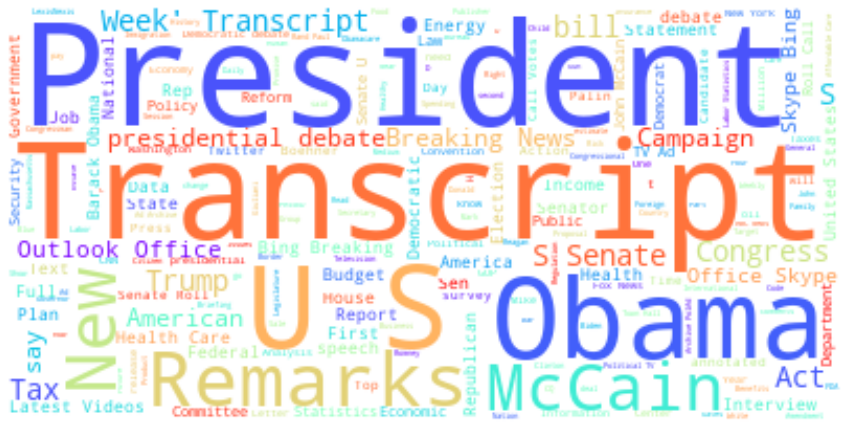

In [61]:
# cluster for true
text = " ".join(i for i in label_0_text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color = 'white', colormap='rainbow').generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

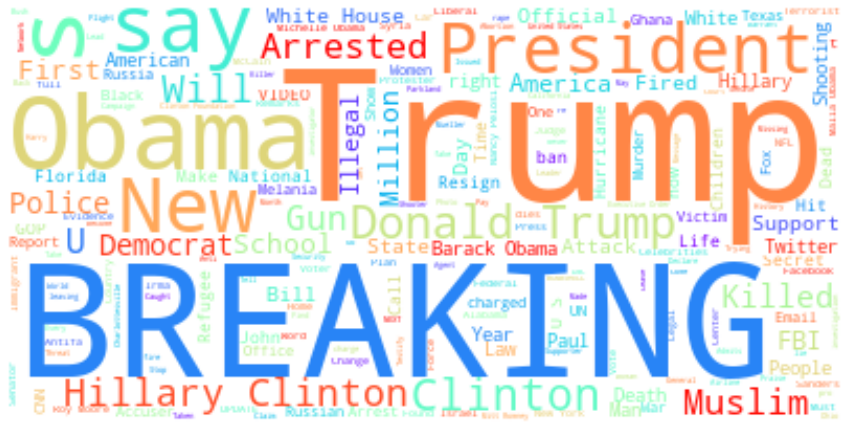

In [58]:
# cluster for false
text = " ".join(i for i in label_1_text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", colormap="rainbow").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()